<a href="https://colab.research.google.com/github/Koscee/pytorch-deep-learning-practice/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Explore an example PyTorch end-to-end workflow

Contents:

1. Data (prepare and load)
2. Build model
3. Fitting the model to data (training)
4. Making predictions and evaluating a model (inference)
5. Saving and loading a model
6. Putting it all together

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for graphs
import matplotlib.pyplot as plt

# Check PyTorch Version
torch.__version__

'2.1.0+cu118'

## 1. Data (preparing and loading)

Data can be almost anything in machine learning.

* Images
* Audio
* Videos
* Text
* Excel spreadsheet
* DNA

Machine learning is a game of two parts:
1. Get data into numerical encoding (representation).
2. Build a model to learn patterns in that numerical representation.

To showcase this, create some known data using the linear regression formula.

Using a linear regression formula `Y = a + bX` to make a staright line with known **parameters**.

In [3]:
# Create known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]),
 50,
 50)

### Spliting data into training and test sets

This is one of the most important concepts in machine

Each split of the dataset serves a specific purpose:

|Split |Purpose |Amount of total data |How often is it used
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |



> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.\n"

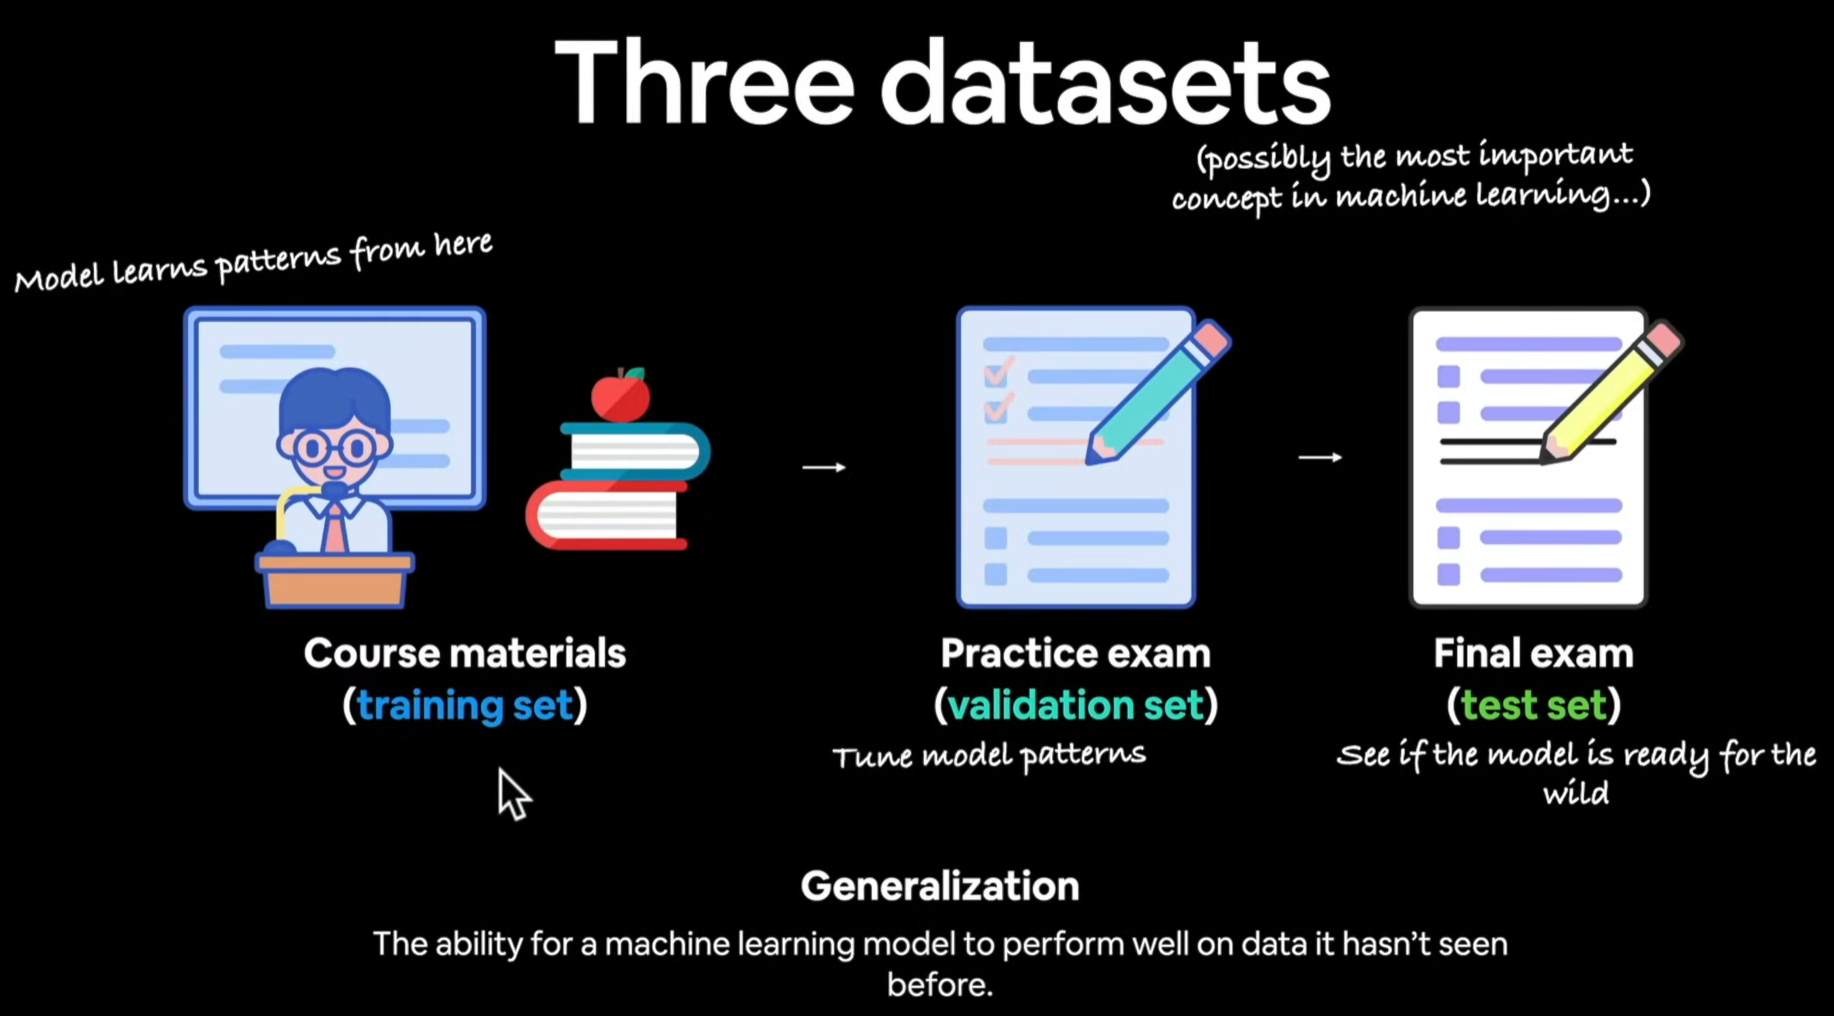


In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualize data

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  '''
    Plots training data, test data and compares predictions.
  '''
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Check if there are predictions
  if predictions is not None:
    # plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show legend
  plt.legend(prop={"size": 14})

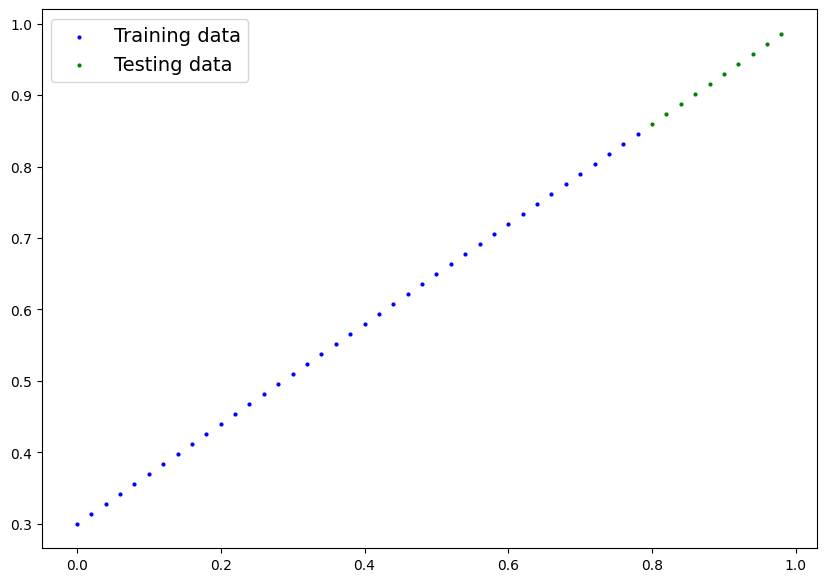

In [6]:
plot_predictions()

## 2. Build model

Resource for OOP Python Classes: https://realpython.com/python3-object-oriented-programming/

What the model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (get closer to) the ideal values (the weight & bias values used to createthe data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [7]:
from torch import nn # nn contains all of PyTorch's building blocks for graphs

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module

  def __init__(self):
    super().__init__()
    # weight and bias starts with a random number and PyTorch updates them  internally
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:  # "x" is the input data
      return self.weights * x + self.bias   # linear regression formula

### PyTorch model building essentials

* **torch.nn** - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* **torch.nn.Parameter** - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* **torch.nn.Module** - the base class for all neural network modules, if you subclass it, you should overwrite forward() method
* **torch.optim** - this is where the optimizers in PyTorch live, they will help with gradient decent
* **def forward()** - all nn.Module subclasses require you to overwrite the forward() method, this method defines what happens in the forward computation

More essential modules via PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html

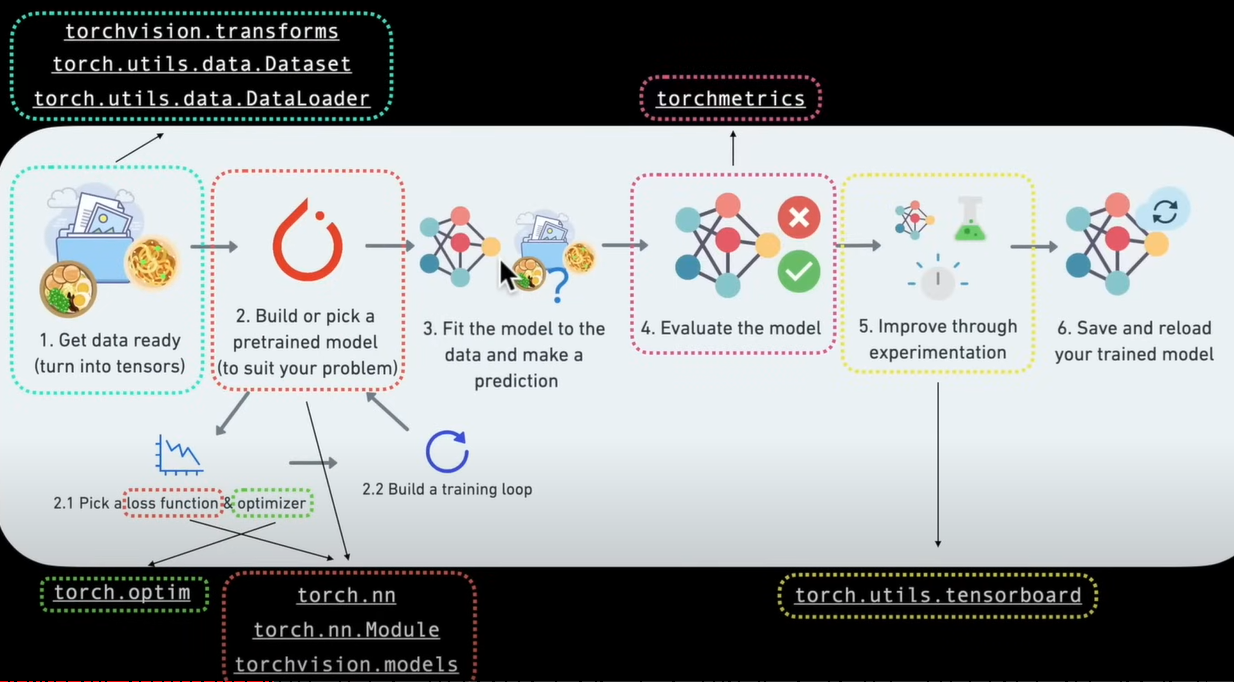

### Checking the contents of our PyTorch model

We can check our model parameters or what's inside our model using `.parameters()`

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (i.e the subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
print(list(model_0.parameters()), "\n")

# List named parameters
print(model_0.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)] 

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


In [9]:
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_model()`

To check the model's predictive power, let's see how well it predicts `y_test` based on `X_test`.
When data is passed through our model, it's going to run it through the `forward()` method.

In [10]:
model_0(X_test) # this is slower bec its keeps track of the gradient using the "grad_fn"

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [11]:
# Make prediction with model

# inference_mode turns off the gradient tracking
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
# no_grad() is similar to inference_mode(), just that inference_mode is faster.
with torch.no_grad():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [13]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

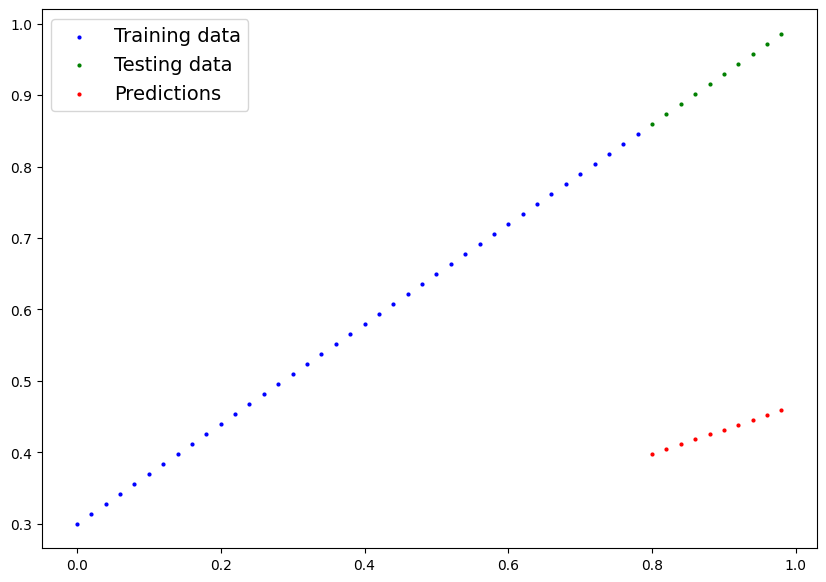

In [14]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (that may be random) to some *known* parameters.

Or in other words, from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong models prediction are is to use a **loss function**.

* Note: Loss function may also be called **cost function** or **criterion** in different areas. For our case, it will be refered to as loss function.

Things needed for training:
* **Loss Function:** A function to measure how wrong your model's prediction are to the ideal outputs. (the lower the better)
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g weight & bias) to improve the loss function.

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])